# Compare scenarios

In [ ]:
years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060] #, 2070, 2080, 2090, 2100]
result_paths = {}
result_paths["coupled (gas free)"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-04_r17_ChrisRemindfreeze_xptgasCCS_c107b/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/"
results_paths["coupled more wind"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-21_r27_more_windbins_freeze/overnight_co2pw-SSP2-PkBudg1000-CHA-higher_minwind_cf_topo-current+FCG"
result_paths["coupled (all free)"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-04_r22_ChrisRemind_c107/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG"
result_paths["PyPSA"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-01-r23_uncoupled_noadj_c105_noisy/overnight_co2pw-SSP2-PkBudg1000-pseudo-coupled_topo-current+FCG"

# remind_paths = {
#     "load": "/p/tmp/ivanra/PyPSA-China-PIK/resources/derived_data/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/remind/yrly_loads.csv",
#     "remind_export": "/p/tmp/ivanra/formatted_remind_outputs/pypsa_export_chris_CHA/"
# }
remind_paths = {
    "load": "/p/tmp/ivanra/PyPSA-China-PIK/resources/derived_data/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/remind/yrly_loads.csv",
    "remind_export": "/p/tmp/ivanra/formatted_remind_outputs/pypsa_export_chris_CHA_v2/"
}

# Boiler Plate

In [ ]:
""" Boiler plate
- import all packages
- emulate snakemake so can load config as usual
- load the network you want
TODO: make it easier to restore old runs
TODO: hide all the boiler pates in a file
"""
%load_ext autoreload
%autoreload 2
%precision %e

import logging
import pypsa
import os.path
import itertools
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import requests

# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
from IPython.utils import io
working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger(__name__)


from _helpers import configure_logging, mock_snakemake
# from make_summary import assign_carriers
import _plot_utilities
import plot_network 


logging.getLogger('plot_network').setLevel(logging.CRITICAL)
logging.getLogger('_plot_utilities').setLevel(logging.CRITICAL)

from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from _plot_utilities import fix_network_names_colors, determine_plottable
from plot_network import plot_cost_map, plot_map

import yaml
from os import PathLike


ERROR 1: PROJ: proj_create_from_database: Open of /home/ivanra/.conda/envs/pypsa-china/share/proj failed


### Load config


In [ ]:


plot_cfg_p = os.path.join(root_dir, "config", "plot_config.yaml")
with open(plot_cfg_p, "r") as f:
    config = yaml.safe_load(f)

In [29]:
# Set the NaN color for plotting
NAN_COLOR = config["plotting"].get("nan_color", "#EEEEEE")
config["plotting"]["tech_colors"]["storage & losses"] = "#236e17"
config["plotting"]["tech_colors"]["storage load"] = "#236e17"

# Make sure we have tech_colors in the config
if "tech_colors" not in config["plotting"]:
    config["plotting"]["tech_colors"] = {
        "solar PV": "#FFC83C",  # Yellow
        "onshore wind": "#3B9AB2",  # Teal
        "offshore wind": "#78B7C5",  # Light blue
        "hydroelectricity": "#4575B4",  # Blue
        "coal": "#4D4D4D",  # Dark gray
        "gas": "#999999",  # Light gray
        "nuclear": "#F46D43",  # Orange
        "biomass": "#A6D96A",  # Green
        "oil": "#8C510A",  # Brown
        "other": "#BEBEBE"  # Silver
    }

## Fetch external data

In [ ]:
def fetch_ember(api_key_file: os.PathLike="../../resources/apikeys/ember.txt") -> pd.DataFrame:
  """Fetches the Ember data for the given API key file."""
  with open(api_key_file, "r") as f:
      my_api_key = f.read()
  base_url = "https://api.ember-energy.org"
  query_url = (
    f"{base_url}/v1/electricity-generation/yearly"
    + f"?entity_code=CHN&is_aggregate_series=false&start_date=2015&api_key={my_api_key}"
  )
  response = requests.get(query_url)
  if response.status_code == 200:
      data = response.json()

  return pd.DataFrame.from_records(data["data"])

ember_mapping = {
    "hydro": "hydroelectricity",
    "wind": "onwind",
    "solar": "solar",
    "coal": "coal",
    "gas": "gas",
    "other fossil": "other fossil",
    "bioenergy": "biomass",
    "net imports": "net imports",
    "nuclear": "nuclear",
}

ember_ = fetch_ember()
ember_data = {}
for year in years:
  year_ = "2024" if year == 2025 else str(year)
  if year > 2025:
     continue
  ember_yr = ember_.query("date==@year_").set_index("series")
  ember_yr.rename({"bioenergy": "biomass", "hydro": "hydroelectricity"}, inplace=True)
  ember_yr.index = ember_yr.index.str.lower().map(ember_mapping)
  ember_data[year] = ember_yr



In [31]:

def to_list(x: str):
    """in case of csv input. conver str to list

    Args:
        x (str): maybe list like string"""
    if isinstance(x, str) and x.startswith("[") and x.endswith("]"):
        split = x.replace("[", "").replace("]", "").split(", ")
        # in case no space in the text-list sep
        if split[0].find(",") >= 0:
            return x.replace("[", "").replace("]", "").split(",")
        else:
            return split
    return x

In [32]:
def read_summary(results_path: os.PathLike, year:int, entry = "supply_energy", cols = 23, header=1) -> pd.DataFrame:
    """Read the summary network from the given path."""
    results_file = os.path.join(results_path, f"summary/ntwk_{year}/{entry}.csv")
    return pd.read_csv(results_file, index_col=list(range(cols)), header=[header])

In [33]:
def fetch_ember_demand(api_key_file: os.PathLike="../../resources/apikeys/ember.txt", 
                       year = 2018) -> pd.DataFrame:
  """Fetches the Ember data for the given API key file."""
  with open(api_key_file, "r") as f:
      my_api_key = f.read()
  base_url = "https://api.ember-energy.org"
  query_url = (
    f"{base_url}/v1/electricity-demand/monthly?entity_code=CHN&start_date={year}-01&end_date={year}-12&api_key={my_api_key}"
  )
  response = requests.get(query_url)
  if response.status_code == 200:
      data = response.json()

  return pd.DataFrame.from_records(data["data"])

ember_demand_mnth = fetch_ember_demand()


In [ ]:
def set_plot_style(
    style_config_file: PathLike = "/p/tmp/ivanra/PyPSA-China-PIK/config/plotting_styles/default_style.mplstyle",
    base_styles=["classic"],
):
    """Set the plot style to base_style(s)

    Args:
        style_config_file (PathLike, optional): Extra style args.
            Defaults to "./config/plotting_styles/default_style.mplstyle".
        base_styles (list, optional): The styles to be applied (in order). Defaults to ["classic"].

    Raises:
        FileNotFoundError: _description_
    """
    style_config_file = os.path.abspath(style_config_file)
    if not os.path.exists(style_config_file):
        raise FileNotFoundError(f"Style config file {style_config_file} not found")

    # plt.style.use only overwrites the specified parts of the previous style -> possible to combine
    plt.style.use(base_styles)
    plt.style.use(style_config_file)


In [35]:
TWa2TWH = 365*24 #/277.77

def map_remind_techs(mapping_file: os.PathLike = "/p/tmp/ivanra/PyPSA-China-PIK/config/templates/techmapping_remind_cc.csv") -> dict:
    """Map REMIND technologies to PyPSA-TECHs."""
    mapping = pd.read_csv(mapping_file)
    mapping = mapping.query("mapper.str.contains('remind') & parameter=='investment'")
    mapping.loc[:,"reference"] = mapping["reference"].apply(to_list)
    mapping = mapping.explode("reference")

    remind_to_pypsa = mapping[["reference", "PyPSA_tech"]].dropna().drop_duplicates().set_index("reference")['PyPSA_tech'].to_dict()
    remind_to_pypsa["ngt"] = "Open-Cycle Gas"
    remind_to_pypsa["pecoal"] = "coal"

    return remind_to_pypsa
    
def read_remind_generation(remind_paths: dict, mapping_file: os.PathLike = "/p/tmp/ivanra/PyPSA-China-PIK/config/templates/techmapping_remind_cc.csv") -> pd.DataFrame:
    """Read the REMIND generation data from the given path."""

    
    remind_gen = pd.read_csv(os.path.join(remind_paths["remind_export"], "p32_seelgen.csv"),
                            names=["year","region", "tech", "generation"], header=1)
    remind_gen.loc[:,"generation"] *= TWa2TWH
    storage_load = pd.read_csv(os.path.join(remind_paths["remind_export"], "p32_se2se.csv"),  names= ["year", "region", "value"], header=1)
    storage_load = storage_load.query("region=='CHA'")
    storage_load.loc[:,"value"] *= -1*TWa2TWH
    storage_load = storage_load[["year","value"]].rename(columns={"value": "storage load"}).set_index("year").T

    remind_load = pd.read_csv(remind_paths["load"])
    remind_load.loc[:,"value"] *= -1/1e6  # Convert to TWh
    remind_load = remind_load.query("load == 'ac'")[["year", "value"]].rename(columns={"value": "electric load"}).set_index("year").T

    remind_to_pypsa = map_remind_techs(mapping_file)
    remind_to_pypsa = {k: v.replace("ccs", "CCS") for k, v in remind_to_pypsa.items()}
    
    remind_gen = remind_gen.query("region=='CHA'").drop(columns=["region"])
    remind_gen.loc[:,"pypsa_tech"] = remind_gen["tech"].map(remind_to_pypsa).fillna(remind_gen["tech"])
    mask = remind_gen.query("tech=='h2turbVRE'").index
    remind_gen.loc[mask, "pypsa_tech"] = "H2 turbine"
    mask2 = remind_gen.query("tech=='hydro'").index
    remind_gen.loc[mask2, "pypsa_tech"] = "hydroelectricity"
    mask3 = remind_gen.query("pypsa_tech=='CCGT'").index
    remind_gen.loc[mask3, "pypsa_tech"] = "Combined-Cycle Gas"

    gen_remind = remind_gen.groupby(["pypsa_tech","year"]).generation.sum().unstack().fillna(0)
    return pd.concat([gen_remind, remind_load, storage_load]).fillna(0)


remind_generation = read_remind_generation(remind_paths)

In [ ]:

def read_remind_capacities(remind_paths: dict) -> pd.DataFrame:

    remind_cap = pd.read_csv(os.path.join(remind_paths["remind_export"], "p32_cap.csv"),
                            names=["year","region", "tech", "capacity"], header=1)
    remind_cap.loc[:,"capacity"] *= 1e6  # Convert to MWh
    remind_cap = remind_cap.query("region=='CHA'").drop(columns=["region"])
    remind_to_pypsa = map_remind_techs()
    remind_to_pypsa = {k: v.replace("ccs", "CCS") for k, v in remind_to_pypsa.items()}
    remind_to_pypsa["hydro"] = "hydroelectricity"
    remind_to_pypsa["gridspv"] = "Transmission Lines"
    remind_to_pypsa["gridcsp"] = "Transmission Lines"
    remind_to_pypsa["gridwindon"] = "Transmission Lines"
    remind_to_pypsa["gridwindoff"] = "Transmission Lines"
    remind_to_pypsa["gridwind"] = "Transmission Lines"
    remind_to_pypsa["elh2VRE"] = "electrolysis"
    remind_to_pypsa["storspv"] = "battery"
    remind_to_pypsa["storwindon"] = "battery"
    remind_to_pypsa["storwindoff"] = "battery"

    remind_cap.loc[:, "pypsa_tech"] = remind_cap.tech.map(remind_to_pypsa).fillna(remind_cap.tech)
    mask = remind_cap.query("pypsa_tech not in ['elh2', 'storcsp', 'storwind']").index
    remind_cap = remind_cap.loc[mask,:] 
    # scaling factors from remind 2 (mind blown)
    remind_cap.loc[remind_cap['tech'].isin(['storwindon','storwindoff']), "capacity"] *= 1.2
    remind_cap.loc[remind_cap['tech'] == "storspv", "capacity"] *= 4
    capacities_remind = remind_cap.groupby(["year", "pypsa_tech"]).capacity.sum().unstack().T.fillna(0)
    return capacities_remind


In [ ]:
## LOAD REMIND DATA
remind_generation = read_remind_generation(remind_paths)
capacities_remind = read_remind_capacities(remind_paths)

caps_remind = capacities_remind.T.query("year in @years").T
caps_remind.columns = pd.MultiIndex.from_tuples([("REMIND",yr ) for yr in caps_remind.columns],  names=["results_path", "year"])


gen_remind = remind_generation.T.query("year in @years").T
gen_remind.columns = pd.MultiIndex.from_tuples([("REMIND",yr ) for yr in gen_remind.columns],  names=["results_path", "year"])

gen_remind.loc["storage & losses"] = gen_remind.loc["storage load"] + gen_remind.loc["wind"]
gen_remind.drop(["storage load", "wind"], inplace=True)

In [ ]:
## LOAD PYPSA OUTPUT DATA


dfs = []
for label, path in result_paths.items():
    for year in years:
        df = read_summary(path, year, cols=2, header=2, entry="supply_energy")
        balance_ac = df.loc["AC"].set_index("carrier").rename(columns={"Unnamed: 3": (label, year)})
        balance_ac.rename({"-": "electric load"}, inplace=True)
        balance_ac = balance_ac.groupby(level=0).sum()
        dfs.append(balance_ac)
balance_ac_all = pd.concat(dfs, axis=1)
balance_ac_all.columns = pd.MultiIndex.from_tuples(balance_ac_all.columns, names=["results_path", "year"])


In [ ]:
## LOAD EMBER DATA
ember_gen_df = pd.DataFrame({
    year: df["generation_twh"]*1e6 for year, df in ember_data.items()
})
ember_gen_df.index.name = "carrier"
ember_gen_df = pd.DataFrame({
    year: df["generation_twh"]*1e6 for year, df in ember_data.items()
})
ember_gen_df.index.name = "carrier"
ember_gen_df.loc["electric load"] = -1*ember_gen_df.sum()

# Convert ember_gen_df columns to MultiIndex to match balance_ac_all
ember_gen_df_multi = ember_gen_df.copy()
ember_gen_df_multi.columns = pd.MultiIndex.from_product([["Ember"], ember_gen_df.columns], names=["results_path", "year"])

## Stack data

In [41]:
# Convert ember_gen_df columns to MultiIndex to match balance_ac_all
ember_gen_df_multi = ember_gen_df.copy()
ember_gen_df_multi.columns = pd.MultiIndex.from_product([["Ember"], ember_gen_df.columns], names=["results_path", "year"])
data = pd.merge(ember_gen_df_multi, balance_ac_all, left_index=True, right_index=True, how="outer").fillna(0)
data.index = data.index.str.replace("ccs", "CCS")

gen_remind = remind_generation.T.query("year in @years").T
gen_remind.columns = pd.MultiIndex.from_tuples([("REMIND",yr ) for yr in gen_remind.columns],  names=["results_path", "year"])

gen_remind.loc["storage & losses"] = gen_remind.loc["storage load"] + gen_remind.loc["wind"]
gen_remind.drop(["storage load", "wind"], inplace=True)

data_all = pd.concat([gen_remind*1E6, data], axis =1 ).fillna(0)
data_all = data_all.rename(columns = {"Ember":"E", "REMIND":"R", "coupled (gas free)":"CP1",  "coupled (all free)":"CP2", "PyPSA":"Py"}, level =0)


# Comparison summary generation

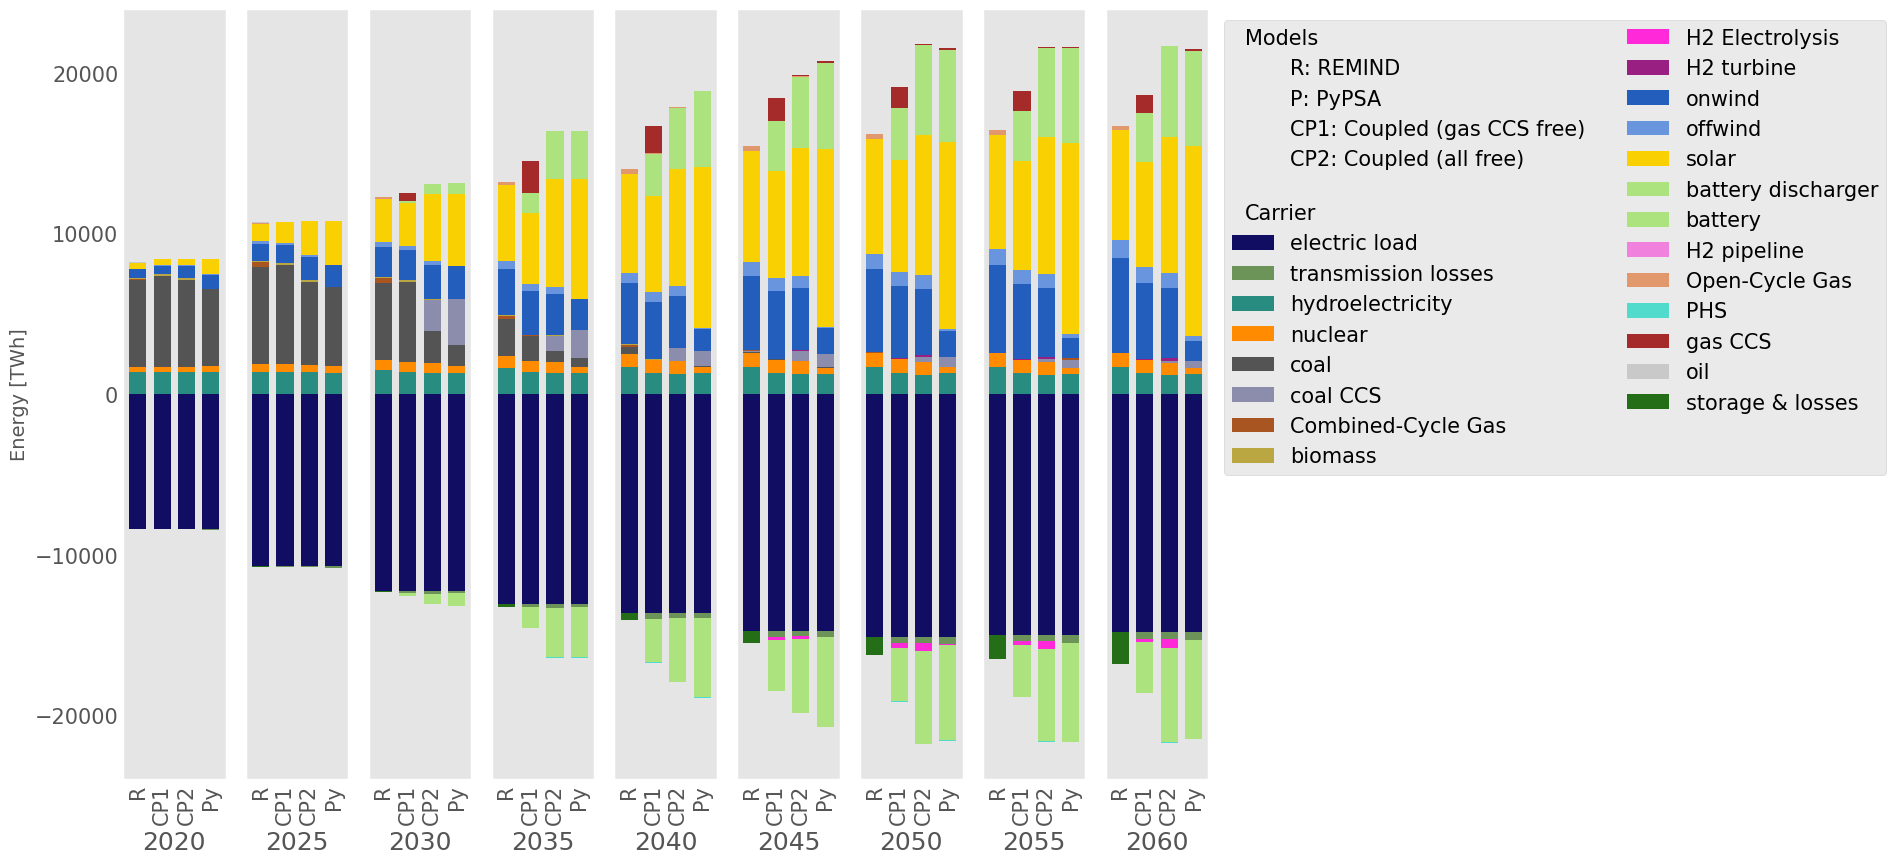

In [ ]:
def build_color_map(df_all: pd.DataFrame, config:dict) -> dict:
    from_names = dict(zip(df_all.index, df_all.index.map(config["plotting"]["tech_colors"])))
    nice2norm = {v: k for k, v in config["plotting"]["nice_names"].items()}
    from_nice_names = dict(zip(df_all.index, df_all.index.map(nice2norm).map(config["plotting"]["tech_colors"])))
    colors = {k: v if str(v) != "nan" else from_nice_names[k] for k, v in from_names.items()}
    return {k: v if str(v) != "nan" else config["plotting"]["nan_color"] for k, v in colors.items()}


def plot_comparison(data, config, unit_conversion, ylabel:str):
        
    data_all_years = data.copy()/unit_conversion
    # Filter out small values for clarity
    data_all_years = data_all_years[abs(data_all_years) > 0.1].fillna(0)

    carrier_colors = []
    for carrier in data_all_years.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
        # Plot with colors
    # Reorder carriers to preferred order
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    new_index = preferred_order.intersection(data_all_years.index).append(
        data_all_years.index.difference(preferred_order)
    )
    data_all_years = data_all_years.loc[new_index]
    groups = data_all_years.T.groupby(level=1)

    colors = build_color_map(data_all_years, config)

    fig, axes = plt.subplots(1, len(groups), sharey=True, figsize=(14,10))
    for ax, (year, group) in zip(axes, groups):
        # The rename_axis function makes the difference
        subplot_df = group.reset_index().set_index("results_path").rename_axis(year).drop(columns=["year"])
        colors_subplot = {k:colors[k] for k in colors if k in subplot_df.columns}
        subplot_df.plot(kind="bar", ax=ax, stacked=True, color=colors_subplot, width=0.7, legend=False )
        ax.tick_params(axis='both', which='both', length=0)
    
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')

    # fig.update_layout(barmode='group', xaxis_tickangle=-45,bargap=0.2,bargroupgap=0.5)
    axes[0].set_ylabel(ylabel, fontsize=14)
    ymax = data_all_years.clip(0).sum().max()
    ymin = data_all_years.clip(upper = 0).sum().min()
    ax.set_ylim([1.1*ymin, 1.1*ymax])


    return ax



In [ ]:

plot_data = data_all.loc[:, data_all.columns.get_level_values("results_path") != "E"]
plot_data = plot_data.loc[~(abs(plot_data) < 3e6).all(axis=1)]

ax = plot_comparison(plot_data, config, 1e6, "Energy [TWh]")
ax.plot([],[], label= "Models", alpha =0)
ax.plot([],[], label= "R: REMIND", alpha =0)
ax.plot([],[], label= "P: PyPSA", alpha =0)
ax.plot([],[], label= "CP1: Coupled (gas CCS free)", alpha =0)
ax.plot([],[], label= "CP2: Coupled (all free)", alpha =0)
ax.plot([],[], label= "\nCarrier", alpha =0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 2)
leg = ax.get_legend()
fig = ax.get_figure()
## Move titles to the left 
for item, label in zip(leg.legend_handles, leg.texts):
    if label._text  in ["\nCarrier","Models"]:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-1.5*width,0))
fig.subplots_adjust(wspace=0.2)

# Summary comparison capacities

In [ ]:
dfs = {}
for label, path in result_paths.items():
    for year in years:
        df = read_summary(path, year, cols=2, header=2, entry="capacities")
        df.loc
        capacities = df.query("bus_carrier=='AC' | end_carrier=='AC' | carrier =='AC'").rename(columns={"Unnamed: 4":"capacity"}).groupby(level=1).capacity.sum()
        dfs[(label, year)] = capacities
capacities_all = pd.concat(dfs, axis=1)
capacities_all.columns = pd.MultiIndex.from_tuples(capacities_all.columns, names=["results_path", "year"])
capacities_all.drop("battery discharger", inplace=True)

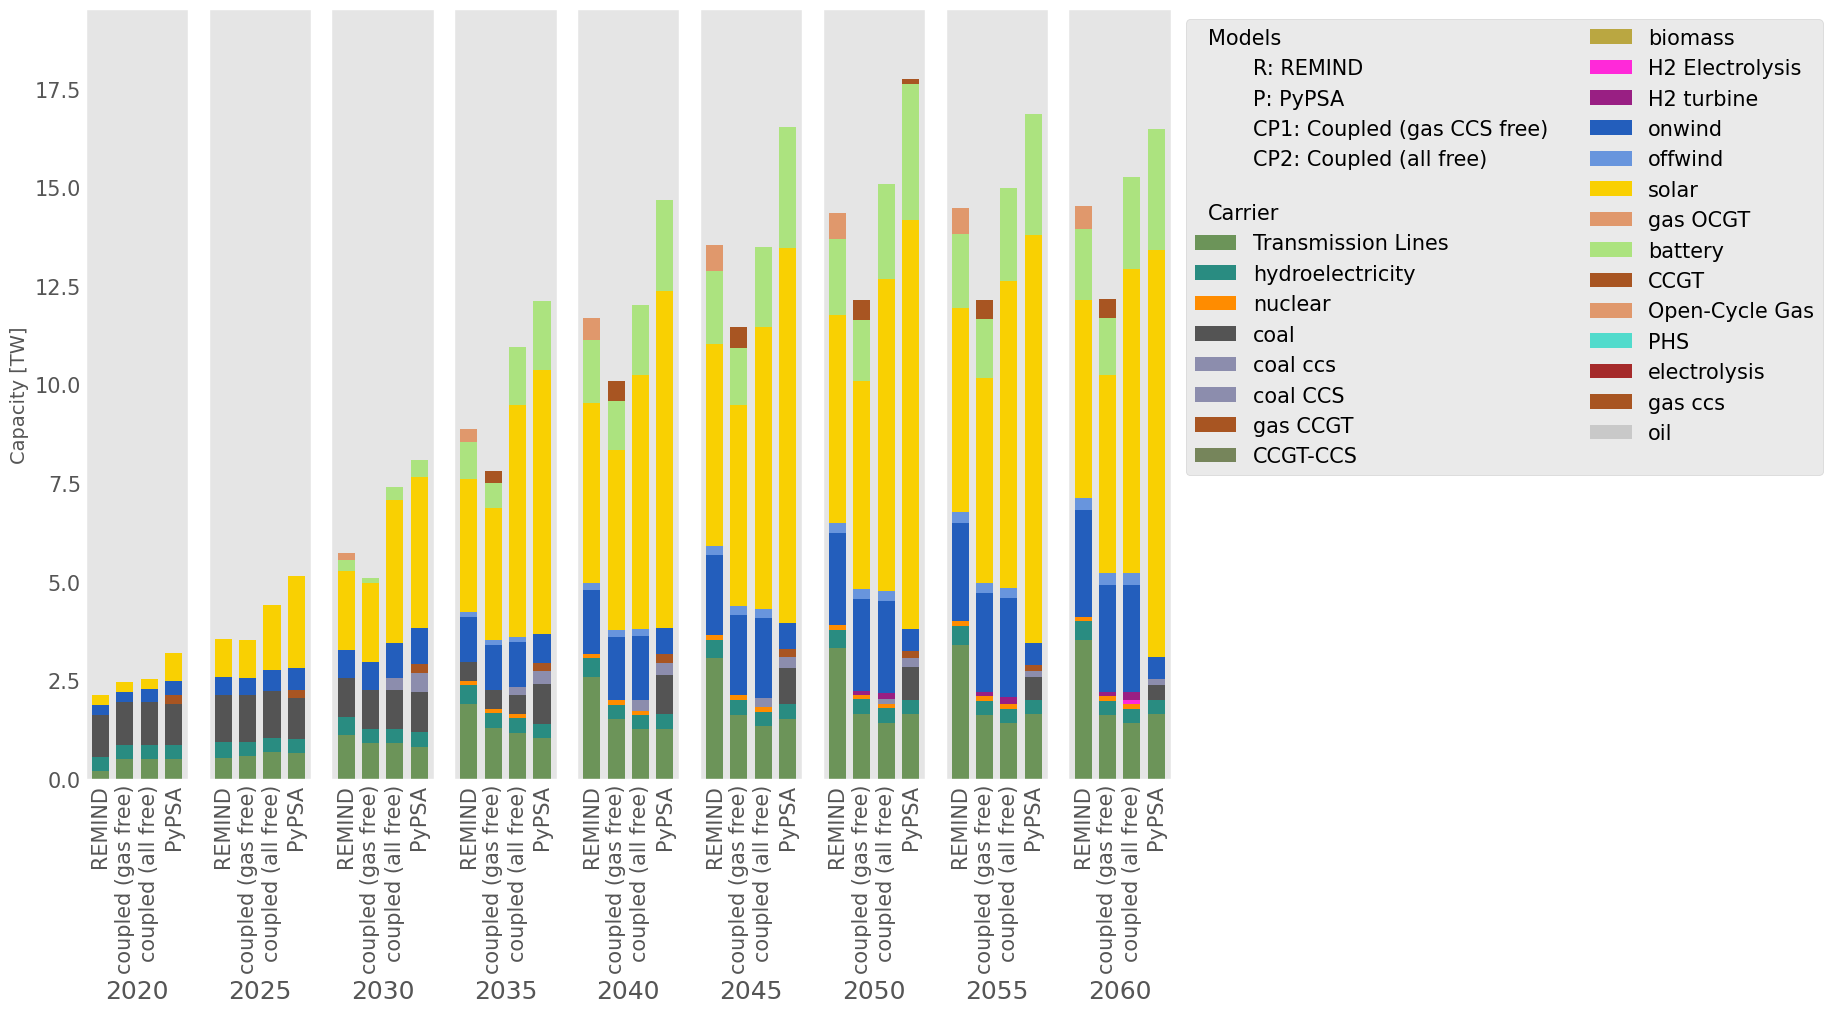

In [45]:
caps_all = pd.concat([caps_remind, capacities_all], axis =1 ).fillna(0)
plot_caps = caps_all.copy()
plot_caps = plot_caps.loc[~(abs(plot_caps) < 1).all(axis=1)]

ax = plot_comparison(plot_caps, config, 1e6, "Capacity [TW]")
ax.plot([],[], label= "Models", alpha =0)
ax.plot([],[], label= "R: REMIND", alpha =0)
ax.plot([],[], label= "P: PyPSA", alpha =0)
ax.plot([],[], label= "CP1: Coupled (gas CCS free)", alpha =0)
ax.plot([],[], label= "CP2: Coupled (all free)", alpha =0)
ax.plot([],[], label= "\nCarrier", alpha =0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 2)
leg = ax.get_legend()
## Move titles to the left 
for item, label in zip(leg.legend_handles, leg.texts):
    if label._text  in ["\nCarrier","Models"]:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-1.5*width,0))
fig = ax.get_figure()
fig.subplots_adjust(wspace=0.2)


In [46]:
caps_all.loc["gas_all",:] = caps_all.loc["Open-Cycle Gas",:] + caps_all.loc["CCGT",:] + caps_all.loc["gas OCGT",:] + caps_all.loc["gas OCGT",:] 
caps_all.loc["gas_all",:].unstack()

year,2020,2025,2030,2035,2040,2045,2050,2055,2060
results_path,,,,,,,,,
PyPSA,53794.144600,53647.984720,53337.647840,51756.361800,40546.106100,14141.873540,5427.843940,32.370220,16.630700
REMIND,79668.979898,168091.474441,240396.630959,370048.037732,571966.030252,661896.294944,675040.259382,638319.701044,571802.868826
coupled (all free),53468.192920,53467.833600,53335.902920,51754.377800,92324.044880,75036.279360,6604.465480,25.113940,2256.782180
coupled (gas free),53466.800000,53466.800000,53334.800000,51752.800000,40506.800000,14092.800000,5424.800000,0.000000,0.000000


# Prices

In [47]:
set_plot_style(
    style_config_file="/p/tmp/ivanra/PyPSA-China-PIK/config/plotting_styles/default_style.mplstyle",
    base_styles=["ggplot"],
)

In [48]:
# TODO harmonize with the others
dfs_in = {}
dfs_in["coupled (gas free)"] = result_paths["coupled (gas free)"]
dfs_in["coupled (all free)"] = result_paths["coupled (all free)"]
dfs_in["PyPSA"] = result_paths["PyPSA"]

prices = []
shares = []
for label, path in dfs_in.items():
    print(label, path)
    for year in years:
        df_pr = read_summary(path, year, cols=2, header=0, entry="weighted_prices").reset_index()
        pathway = df_pr.columns[-1]
        year = int(df_pr.loc[0, pathway])
        df_pr.set_index("co2_pathway", inplace=True)
        df_pr.drop("planning_horizons", inplace=True)
        df_pr.rename(columns = {pathway: (year, label)}, inplace=True)

        df = read_summary(path, year, cols=2, header=2, entry="supply_energy")
        balance_ac = df.loc["AC"].set_index("carrier").rename(columns={"Unnamed: 3": (label, year)})
        balance_ac.rename({"-": "electric load"}, inplace=True)
        balance_ac = balance_ac.groupby(level=0).sum().drop("H2 turbine")
        load = balance_ac.query("carrier.str.lower().str.contains('load') | carrier.str.lower().str.contains('loss')").sum()*-1
        vre_share = balance_ac.clip(0).query("carrier in ['solar','offwind','onwind', 'hydroelectricity']").sum()/load*100
        
        prices.append(df_pr)
        shares.append(vre_share.rename((label, year)))
        
prices_all = pd.concat(prices, axis=1)
prices_all.columns = pd.MultiIndex.from_tuples(prices_all.columns, names=[ "year", "results_path",])
shares_all = pd.concat(shares, axis=0)
shares_all.index = pd.MultiIndex.from_tuples(shares_all.index, names=["results_path", "year"])
shares_all = shares_all.unstack(1)
prices_all.dropna(inplace=True)


coupled (gas free) /p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-04_r17_ChrisRemindfreeze_xptgasCCS_c107b/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/
coupled (all free) /p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-04_r22_ChrisRemind_c107/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG
PyPSA /p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-01-r23_uncoupled_noadj_c105_noisy/overnight_co2pw-SSP2-PkBudg1000-pseudo-coupled_topo-current+FCG


Text(0, 0, 'PyPSA')
Text(0, 0, 'coupled (all free)')
Text(0, 0, 'coupled (gas free)')
Text(0, 0, '\nQuantity')
Text(0, 0, 'Price')
Text(0, 0, 'VRE share')


NameError: name 'AutoMinorLocator' is not defined

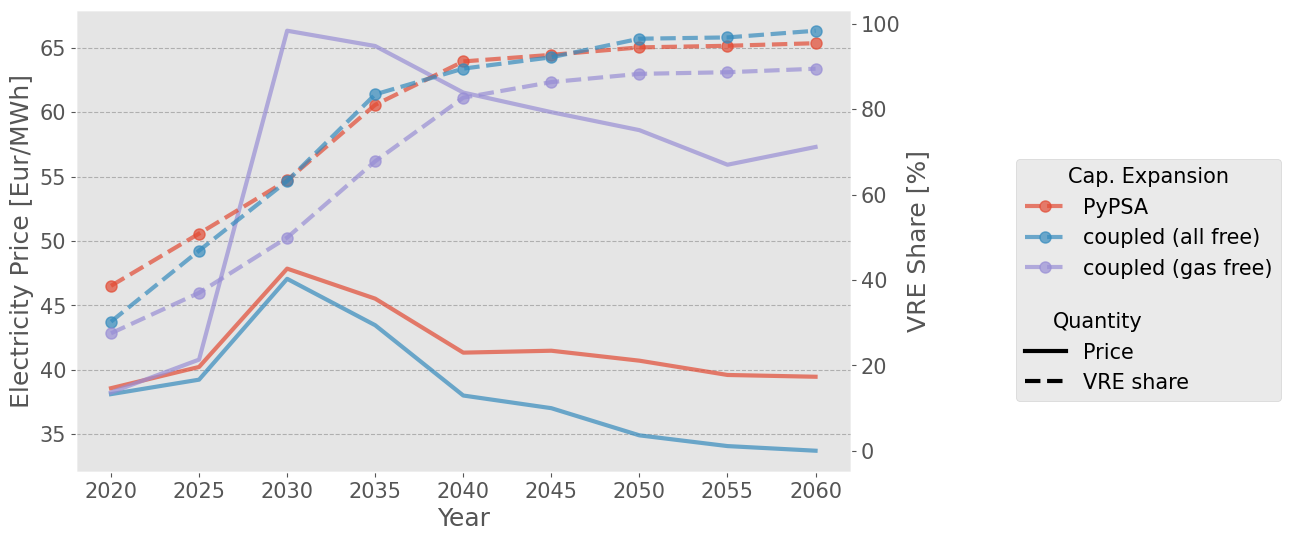

In [49]:
from matplotlib.lines import Line2D


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax.twinx()  # Create a second y-axis for the share plot

# Plot solid and dashed lines
prices_all.unstack().droplevel(2).unstack().plot(ax=ax, lw=3, alpha=0.7)
shares_all.T.plot(ax=ax2, lw=3, marker='o', markersize=8, alpha=0.7, ls="--")

ax.set_ylabel("Electricity Price [Eur/MWh]")
ax2.set_ylabel("VRE Share [%]")
ax.set_xlabel("Year")
ax.legend_.remove()
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot([2025], [0], color="none", label="\nQuantity", lw=0)  # Dummy line for legend
# Add custom legend for solid and dashed lines, appending to existing legend
handles, labels = ax2.get_legend_handles_labels()
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle='-'),
    Line2D([0], [0], color='black', lw=3, linestyle='--')
]
handles += custom_lines
labels += ['Price', 'VRE share']
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.2, 0.7), title="Cap. Expansion")

leg = ax2.get_legend()
## Move titles to the left 
for item, label in zip(leg.legend_handles, leg.texts):
    print(label)
    if label._text  in ["Cap. Expansion","\nQuantity"]:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-1*width,0))

ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, which='minor')
ax.set_ylim([25, ax2.get_ylim()[-1]])
ax2.set_ylim([25, ax2.get_ylim()[-1]])
plt.tight_layout()
plt.show()

# Comparison

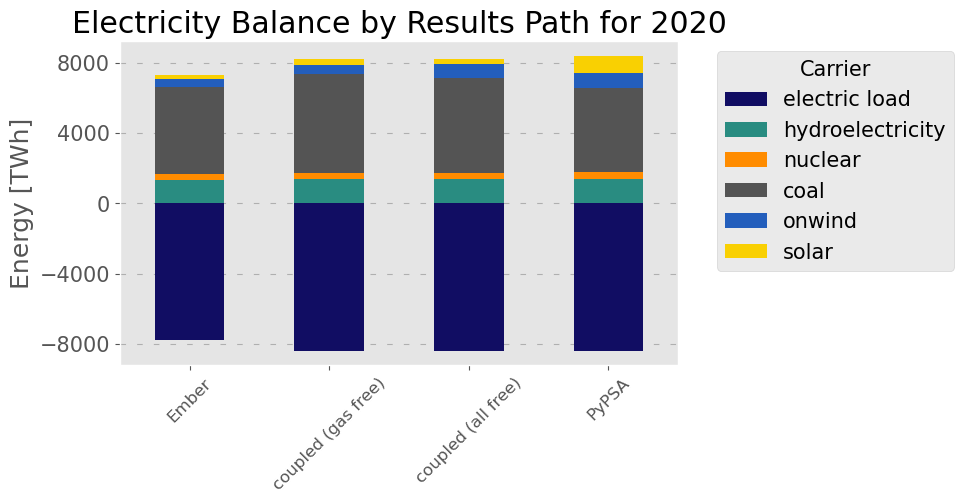

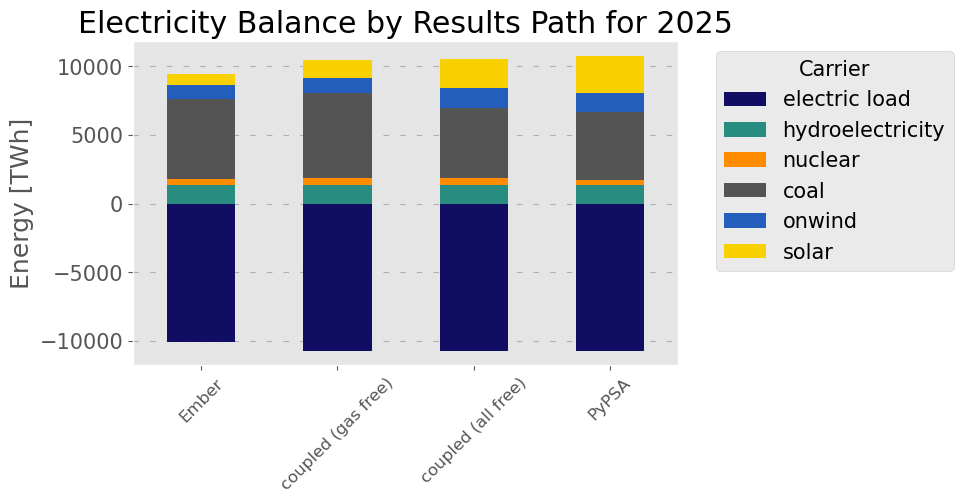

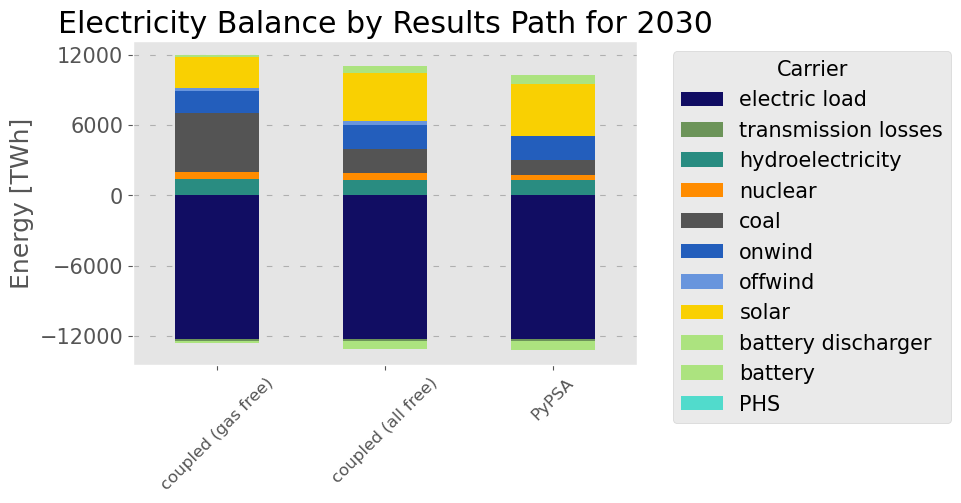

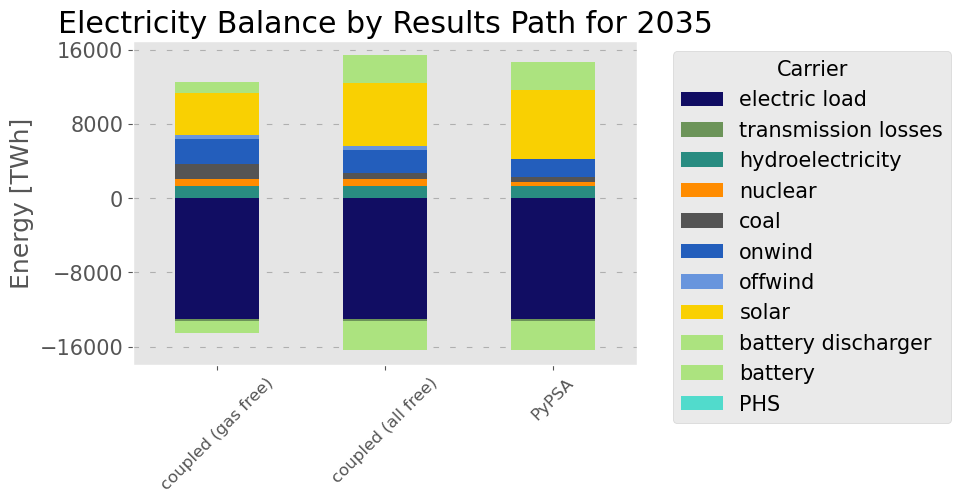

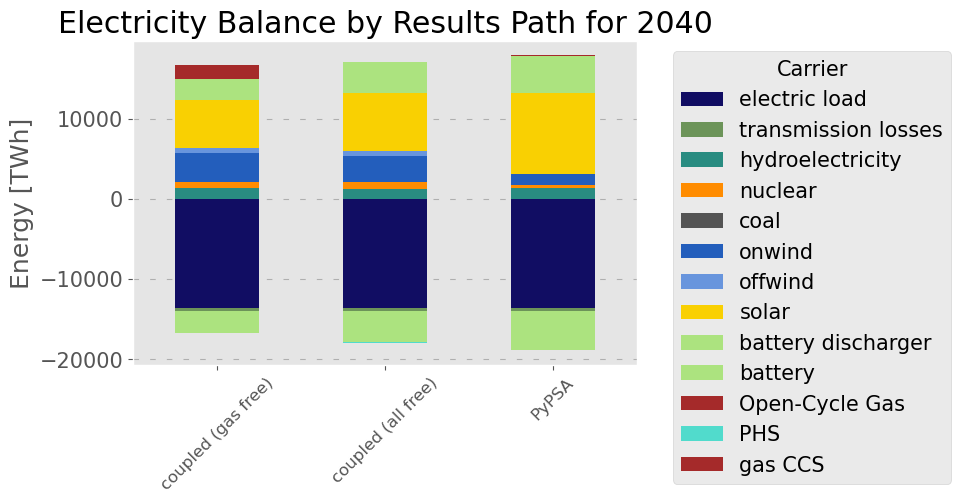

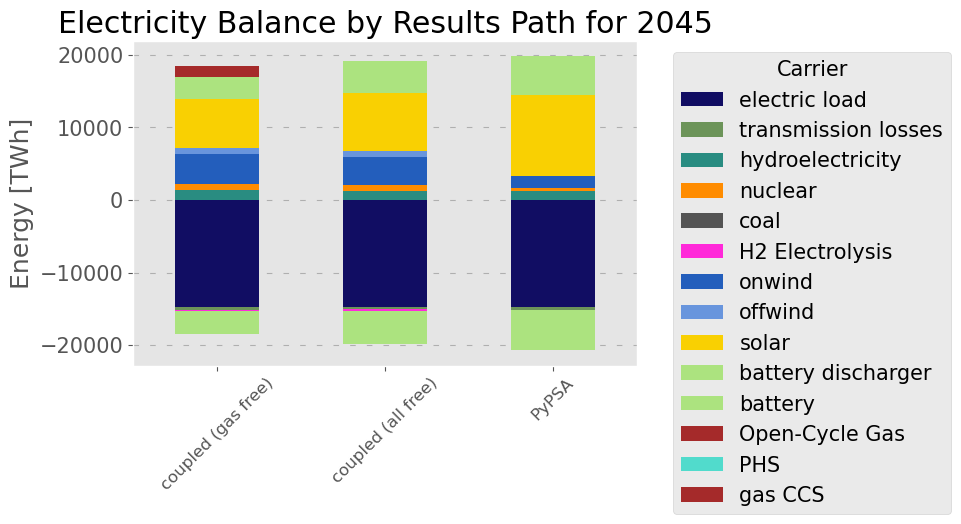

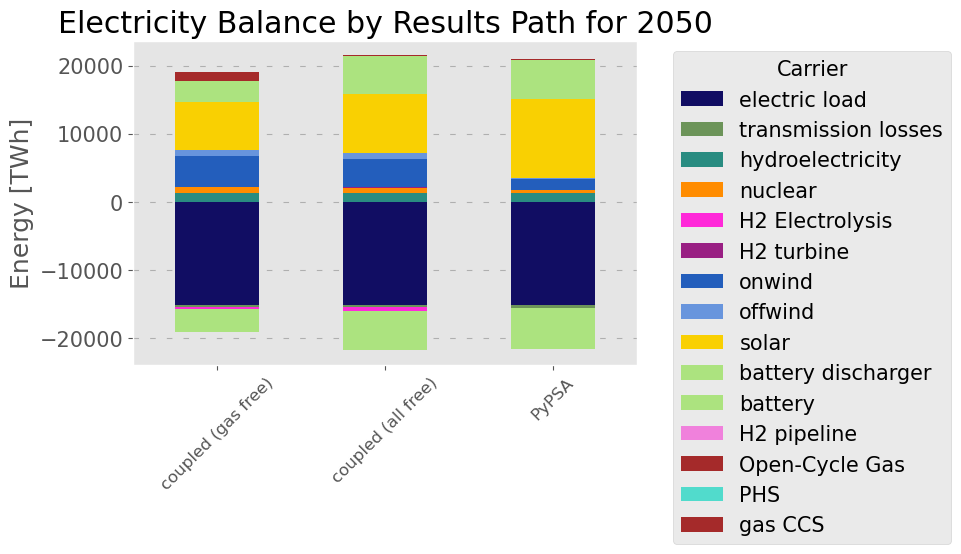

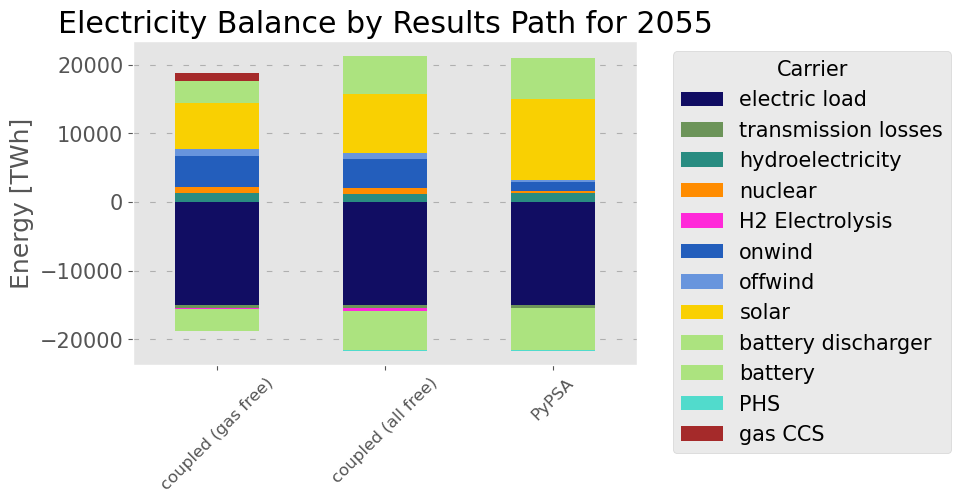

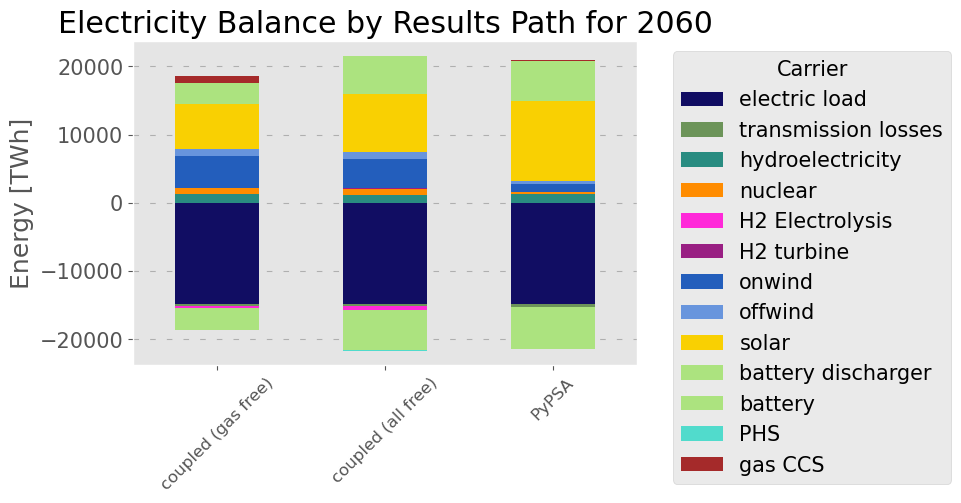

In [ ]:
# Plot the data dataframe for a selected year as stacked bars per results_path
for selected_year in years:
    plot_df =  data.loc[:,data.columns.get_level_values('year')==selected_year]

    # Prepare data for plotting: columns are (results_path, year), index is carrier
    data_year = plot_df.copy()/1e6
    data_year = data_year[abs(data_year)>0.1].dropna()
    # Prepare colors for carriers using config["plotting"]["tech_colors"], fallback to NAN_COLOR
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    # Reorder data_year to preferred_order, append missing carriers at the end
    new_index = preferred_order.intersection(data_year.index).append(
        data_year.index.difference(preferred_order)
    )
    data_year = data_year.loc[new_index].droplevel(1, axis=1)
    carrier_colors = []
    for carrier in data_year.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
    # Plot with colors
    ax = data_year.T.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=carrier_colors
    )
    
    # Plot
    # ax = data_year.T.plot(kind="bar", stacked=True, figsize=(10, 6))
    ax.set_ylabel("Energy [TWh]")
    ax.set_xlabel(None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid(axis='y', linestyle=(0, (5, 10)), alpha=0.7)
    ax.set_title(f"Electricity Balance by Results Path for {selected_year}")
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
    plt.tight_layout()
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

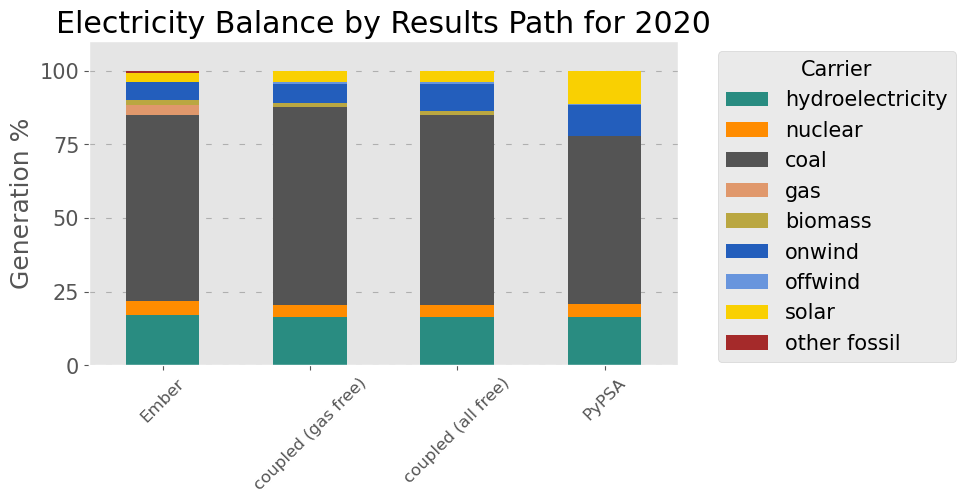

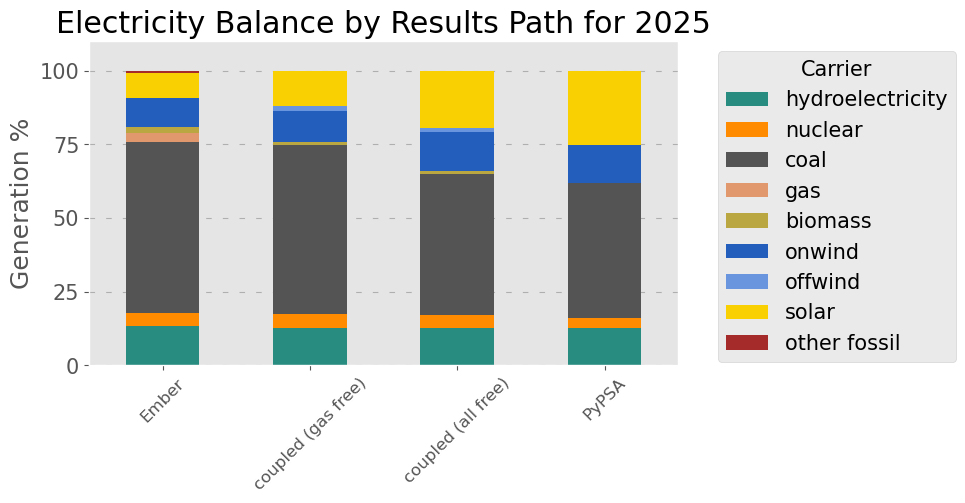

In [ ]:
# Plot the data dataframe for a selected year as stacked bars per results_path
for selected_year in years[:2]:
    plot_df =  data.loc[:,data.columns.get_level_values('year')==selected_year].copy()
    
    plot_df.drop("electric load", inplace=True)
    plot_df.clip(lower=0, inplace=True)
    tot = plot_df.sum(axis=0)
    threshold = 0.2*tot/100
    plot_df[plot_df<=threshold] = 0
    plot_df = plot_df[(plot_df != 0).any(axis=1)]
    # Prepare data for plotting: columns are (results_path, year), index is carrier
    data_year = plot_df/plot_df.sum()*100
    # data_year = data_year[abs(data_year)>0.1].dropna()
    # Prepare colors for carriers using config["plotting"]["tech_colors"], fallback to NAN_COLOR
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    # Reorder data_year to preferred_order, append missing carriers at the end
    new_index = preferred_order.intersection(data_year.index).append(
        data_year.index.difference(preferred_order)
    )
    data_year = data_year.loc[new_index].droplevel(1, axis=1)
    carrier_colors = []
    for carrier in data_year.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
    # Plot with colors
    ax = data_year.T.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=carrier_colors
    )
    
    # Plot
    # ax = data_year.T.plot(kind="bar", stacked=True, figsize=(10, 6))
    ax.set_ylabel("Generation %")
    ax.set_xlabel(None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid(axis='y', linestyle=(0, (5, 10)), alpha=0.7)
    ax.set_title(f"Electricity Balance by Results Path for {selected_year}")
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
    plt.tight_layout()
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

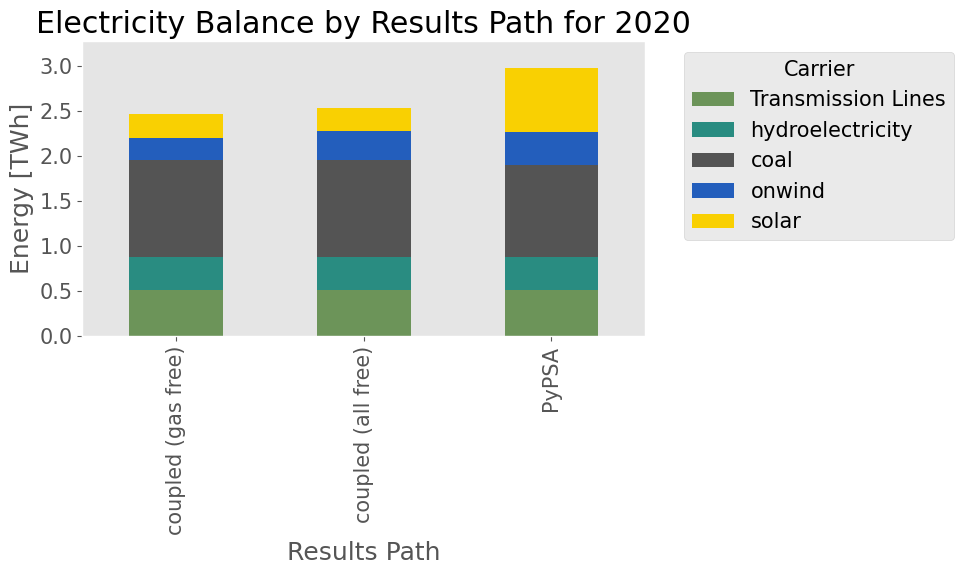

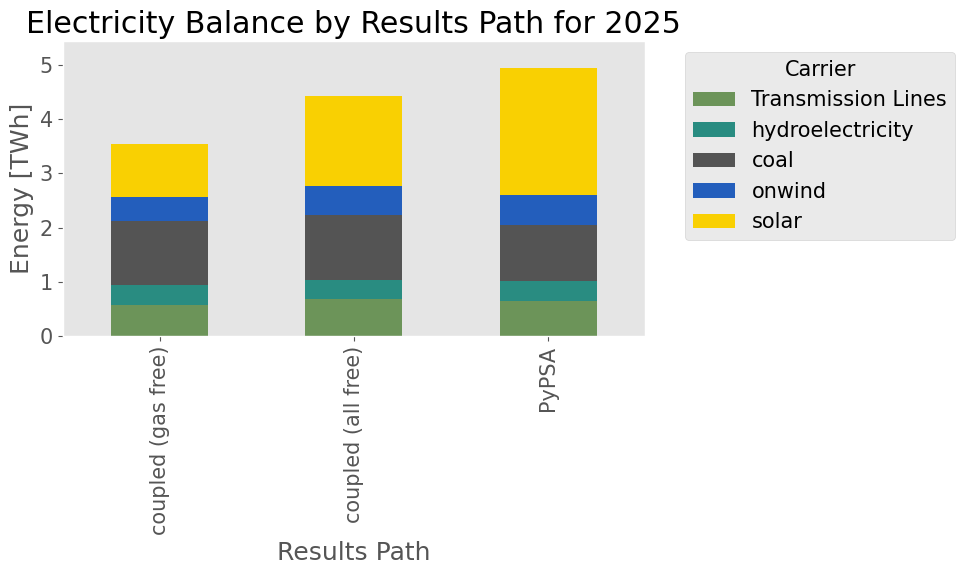

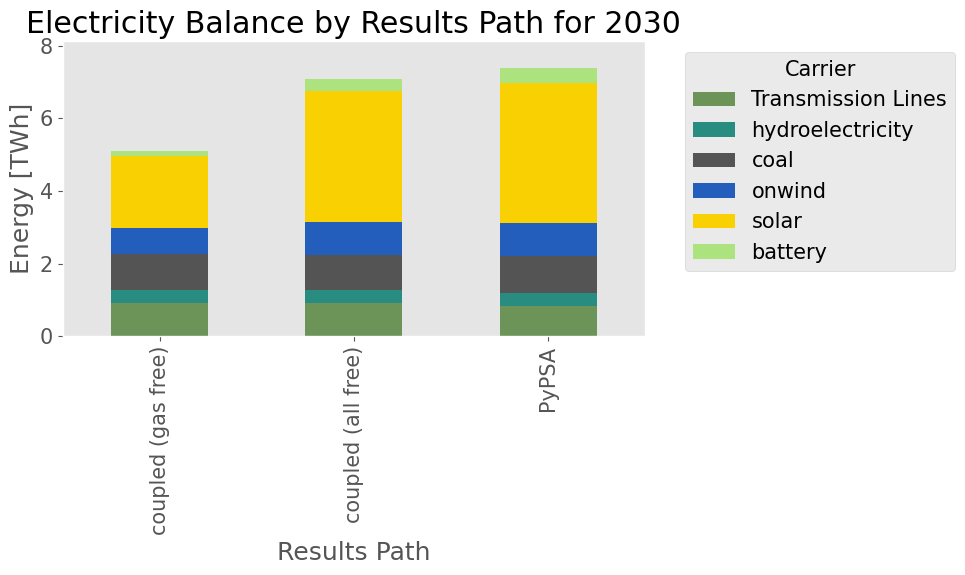

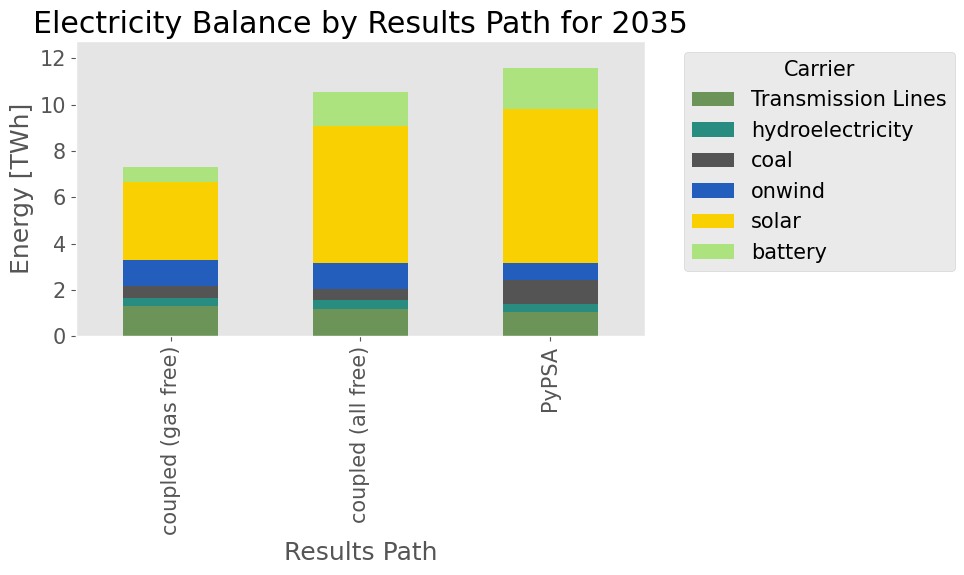

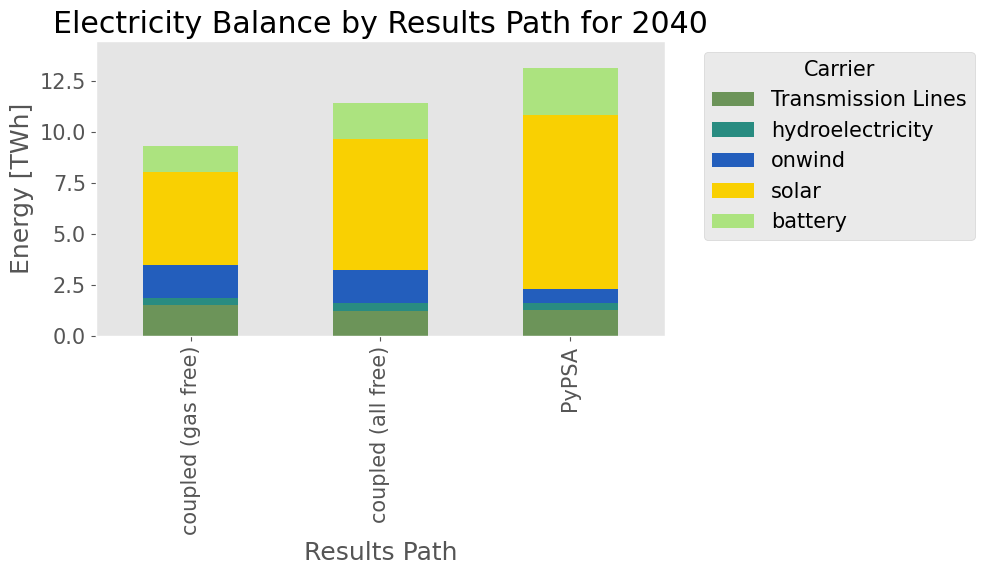

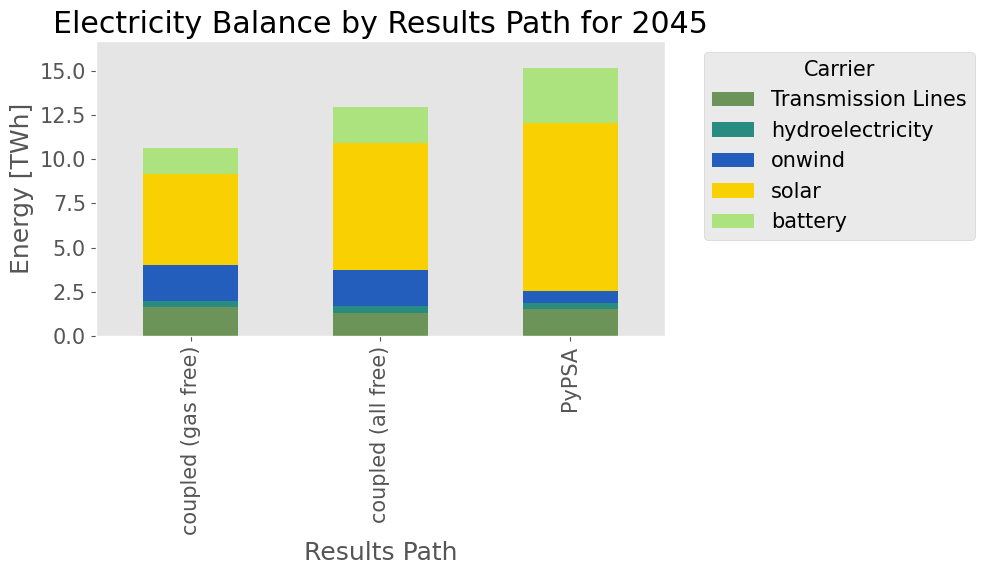

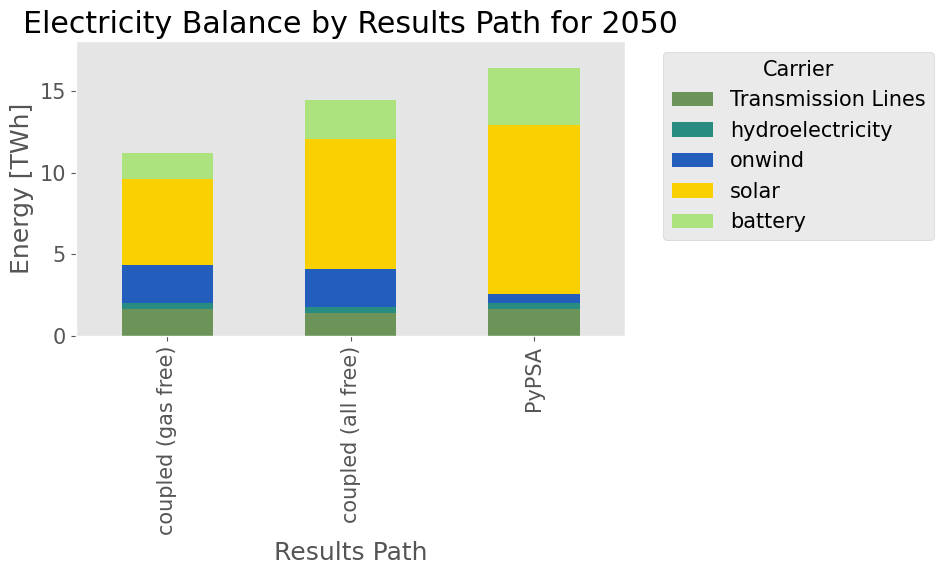

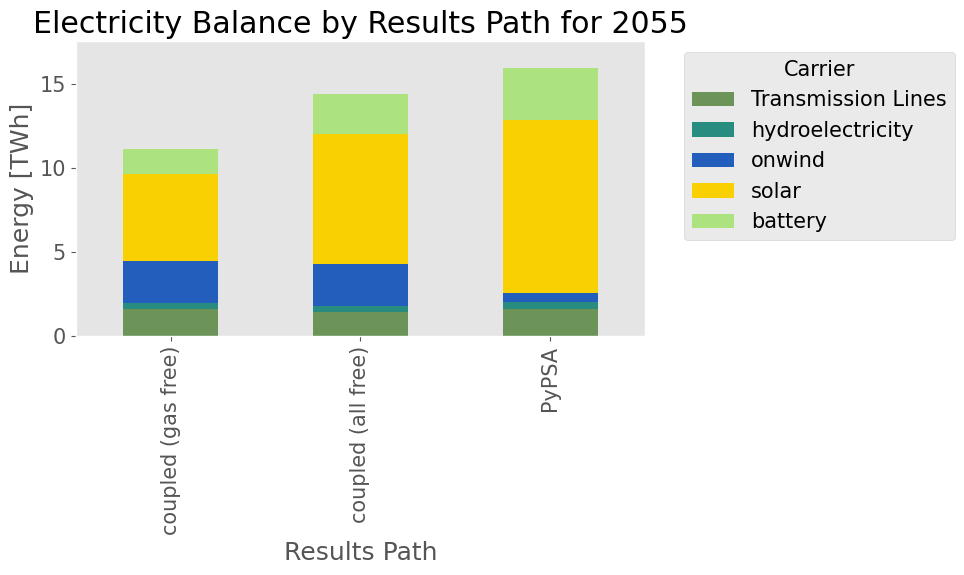

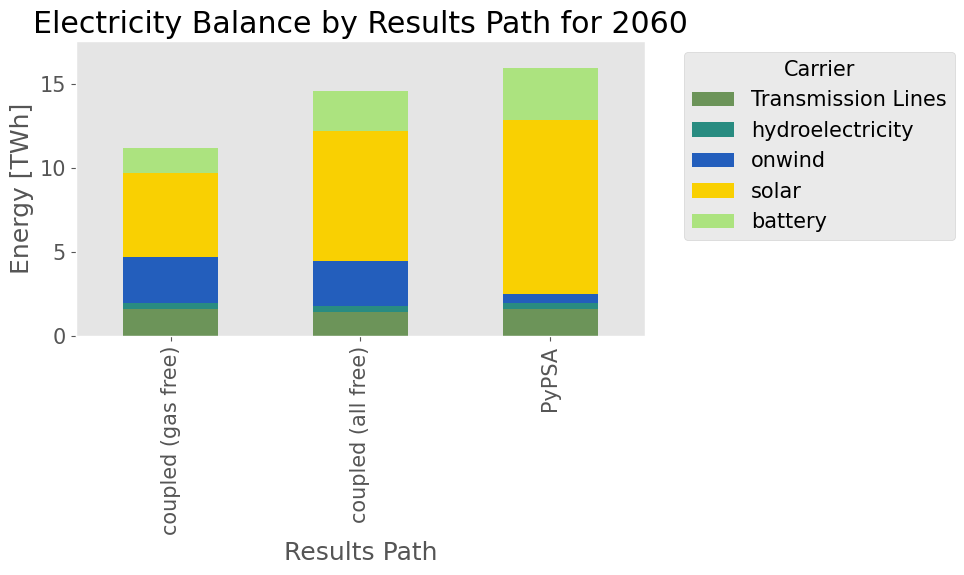

In [ ]:
# Plot the data dataframe for a selected year as stacked bars per results_path
for selected_year in years:
    plot_df =  capacities_all.loc[:,capacities_all.columns.get_level_values('year')==selected_year]

    # Prepare data for plotting: columns are (results_path, year), index is carrier
    data_year = plot_df.copy()/1e6
    data_year = data_year[abs(data_year)>0.1].dropna()
    # Prepare colors for carriers using config["plotting"]["tech_colors"], fallback to NAN_COLOR
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    # Reorder data_year to preferred_order, append missing carriers at the end
    new_index = preferred_order.intersection(data_year.index).append(
        data_year.index.difference(preferred_order)
    )
    data_year = data_year.loc[new_index].droplevel(1, axis=1)
    carrier_colors = []
    for carrier in data_year.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
    # Plot with colors
    ax = data_year.T.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=carrier_colors
    )
    
    # Plot
    # ax = data_year.T.plot(kind="bar", stacked=True, figsize=(10, 6))
    ax.set_ylabel("Energy [TWh]")
    ax.set_xlabel("Results Path")
    ax.set_title(f"Electricity Balance by Results Path for {selected_year}")
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
from matplotlib import pyplot as plt
# Plot with colors
import matplotlib.backends.backend_pdf

# Plot the data dataframe for a selected year as stacked bars per results_path
for selected_year in years:
    plot_df =  data.loc[:,data.columns.get_level_values('year')==selected_year]

    # Prepare data for plotting: columns are (results_path, year), index is carrier
    data_year = plot_df.copy()/1e6
    # Prepare colors for carriers using config["plotting"]["tech_colors"], fallback to NAN_COLOR
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    # Reorder data_year to preferred_order, append missing carriers at the end
    new_index = preferred_order.intersection(data_year.index).append(
        data_year.index.difference(preferred_order)
    )
    data_year = data_year.loc[new_index].droplevel(1, axis=1)
    carrier_colors = []
    for carrier in data_year.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))


    # Create a PDF slideshow
    pdf_path = os.path.join(workflow_dir, "notebooks", f"electricity_balance_slideshow_{years[0]}_{years[-1]}.pdf")
    with matplotlib.backends.backend_pdf.PdfPages(pdf_path) as pdf:
        for selected_year in years:
            plot_df =  data.loc[:,data.columns.get_level_values('year')==selected_year]
            data_year = plot_df.copy()/1e6
            preferred_order = pd.Index(config["plotting"]["preferred_order"])
            new_index = preferred_order.intersection(data_year.index).append(
                data_year.index.difference(preferred_order)
            )
            data_year = data_year.loc[new_index].droplevel(1, axis=1)
            carrier_colors = []
            for carrier in data_year.index:
                carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
            ax = data_year.T.plot(
                kind="bar",
                stacked=True,
                figsize=(10, 6),
                color=carrier_colors
            )
            ax.set_ylabel("Energy [TWh]")
            ax.set_xlabel("Results Path")
            ax.set_title(f"Electricity Balance by Results Path for {selected_year}")
            ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
            plt.tight_layout()
            pdf.savefig(ax.figure)
            plt.close(ax.figure)
    print(f"PDF slideshow saved to {pdf_path}")
    ax.set_ylabel("Energy [TWh]")
    ax.set_xlabel("Results Path")
    ax.set_title(f"Electricity Balance by Results Path for {selected_year}")
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
    plt.tight_layout()
    plt.show()

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

PDF slideshow saved to /p/tmp/ivanra/PyPSA-China-PIK/workflow/notebooks/electricity_balance_slideshow_2020_2060.pdf


<Figure size 640x480 with 0 Axes>

# REMIND

In [ ]:
mapping = pd.read_csv("/p/tmp/ivanra/PyPSA-China-PIK/config/templates/techmapping_remind_cc.csv")
mapping = mapping.query("mapper.str.contains('remind')")
mapping["reference"] = mapping["reference"].apply(to_list)
mapping = mapping.explode("reference")

remind_to_pypsa = mapping[["reference", "PyPSA_tech"]].dropna().drop_duplicates().set_index("reference")['PyPSA_tech'].to_dict()
remind_to_pypsa["ngt"] = "gas"
remind_to_pypsa["pecoal"] = "coal"

In [ ]:
TWa2MWH = 1e6*365*24

remind_gen = pd.read_csv("/p/tmp/ivanra/formatted_remind_outputs/pypsa_export_chris_CHA/p32_pe2seelTe.csv", names=["year","region", "tech", "generation"], header=1)
remind_gen["generation"] *= TWa2MWH
remind_gen["pypsa_tech"] = remind_gen["tech"].map(remind_to_pypsa).fillna(remind_gen["tech"])

In [ ]:
remind_load = pd.read_csv("/p/tmp/ivanra/PyPSA-China-PIK/resources/derived_data/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/remind/yrly_loads.csv")
remind_load["value"] *= -1/1e6  # Convert to TWh

In [ ]:


remind_gen2 = pd.read_csv("/p/tmp/ivanra/formatted_remind_outputs/pypsa_export_chris_CHA/p32_seelgen.csv",
                           names=["year","region", "tech", "generation"], header=1)
remind_gen2["generation"] *= TWa2TWH
remind_gen2 = remind_gen2.query("region=='CHA'").drop(columns=["region"])
remind_gen2["pypsa_tech"] = remind_gen2["tech"].map(remind_to_pypsa).fillna(remind_gen2["tech"])
mask = remind_gen2.query("tech=='h2turbVRE'").index
remind_gen2.loc[mask, "pypsa_tech"] = "H2 turbine"
mask2 = remind_gen2.query("tech=='hydro'").index
remind_gen2.loc[mask2, "pypsa_tech"] = "hydroelectricity"
mask3 = remind_gen2.query("pypsa_tech=='CCGT'").index
remind_gen2.loc[mask3, "pypsa_tech"] = "gas"


In [ ]:
# h2gen = remind_gen2.query("tech=='h2turbVRE'").copy()
# h2gen.pypsa_tech = "Load for H2"
# h2gen["generation"] *=-1
# remind_gen2 = pd.concat([remind_gen2, h2gen], ignore_index=True)

In [ ]:
se2se = pd.read_csv("/p/tmp/ivanra/formatted_remind_outputs/pypsa_export_chris_CHA/p32_se2se.csv", names= ["year", "region", "value"], header=1)
se2se = se2se.query("region=='CHA'").set_index("year")
se2se.value *= -1*TWa2TWH # Convert to TWh


In [ ]:
plot_order = config["plotting"]["preferred_order"]

In [ ]:
plot_remind2 = remind_gen2.query("2020<=year<=2060").pivot_table(index="year", columns="pypsa_tech", values="generation", aggfunc="sum").fillna(0)
ylim = (plot_remind2.sum(axis=1).max()*1.1)
plot_remind2["electric load"] =  remind_load.set_index("year")["value"]
plot_remind2["storage load"] = se2se.value
order = [p for p in plot_order if p in plot_remind2.columns] + [t for t in plot_remind2.columns if t not in plot_order]
plot_remind2 = plot_remind2[order]
config["plotting"]["tech_colors"]["storage load"] = "black"
config["plotting"]["tech_colors"]["storage & losses"] = "black"
tech_colors = []
for carrier in plot_remind2.columns:
    tech_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))

ax = plot_remind2.query("year<=2060").plot(kind="bar", stacked=True, color=tech_colors, figsize=(7, 6))
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("REMIND Energy [TWh]")
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_ylim([plot_remind2["electric load"].min()*1.1//10000*10000,ylim])

TypeError: dtype 'pypsa_tech
gas    float64
gas    float64
dtype: object' not understood

In [ ]:
plot_remind2

pypsa_tech,hydroelectricity,nuclear,coal,coal ccs,gas,biomass,H2 turbine,onwind,offwind,solar,electric load,csp,gas ccs,geohdr,oil,wind,storage load
year,,,,,,,,,,,,,,,,,
2020,1370.761084,341.963770,5375.247905,0.696773,145.907950,69.664738,0.000000,546.744476,12.079367,330.206091,-8396.743504,1.151589,0.000000,0.245547,34.641481,0.000000,NaN
2025,1385.842481,472.497119,6068.985348,2.987651,368.105997,68.897429,0.000000,1081.798459,132.878652,1105.893491,-10712.006463,1.471721,0.000536,0.344005,23.581333,-4.030947,-1.277759
2030,1540.901615,595.503941,4813.516477,2.985245,403.315171,60.219104,0.000126,1879.340228,274.679592,2722.830158,-12269.363063,1.461123,0.000536,1.223466,9.094693,-10.143988,-35.708411
2035,1657.233127,704.046010,2304.743728,2.973175,409.211542,50.972482,0.000110,2843.778369,472.627859,4745.118191,-13031.385383,1.407693,0.000534,2.285127,0.000219,-19.373841,-163.012783
2040,1721.284660,784.075468,423.535385,2.936858,387.126067,41.093484,0.000096,3797.037839,667.370640,6175.823197,-13615.337443,1.400446,0.000526,2.777796,0.000326,-25.537674,-389.125344
2045,1725.265247,829.344866,108.933720,2.854543,381.978232,30.760670,0.000095,4614.900262,831.189859,6904.506854,-14712.470895,1.543406,0.000526,2.777796,0.000427,-35.170864,-721.585609
2050,1725.265247,845.926073,0.061156,2.697310,346.841384,20.614047,8.028015,5167.014317,934.213977,7135.845125,-15095.101345,1.619090,0.000526,2.777796,0.000512,-50.095594,-1095.803231
2055,1725.265247,837.887255,0.043001,2.429066,301.980109,11.581401,22.219061,5478.910771,998.909784,7049.456517,-14980.312481,1.643310,0.000526,2.777796,0.000565,-72.216425,-1452.791929
2060,1725.265247,817.817398,0.025583,2.006547,270.498094,4.565178,50.793297,5875.643883,1103.314251,6881.793490,-14805.887132,1.673618,0.000526,2.777796,0.000620,-123.056047,-1930.288396


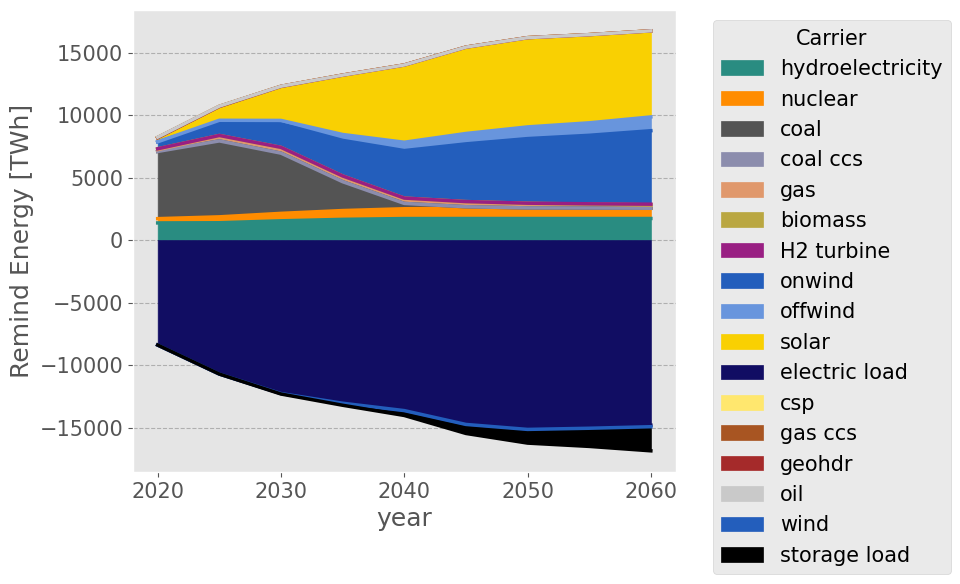

In [ ]:
ax = plot_remind2.query("year<=2060").plot(kind="area", stacked=True, color=tech_colors, figsize=(7, 6))
ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel("Remind Energy [TWh]")
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
# ax.set_ylim([0,(plot_remind2.sum(axis=1).max()*1.1)//10000*10000])

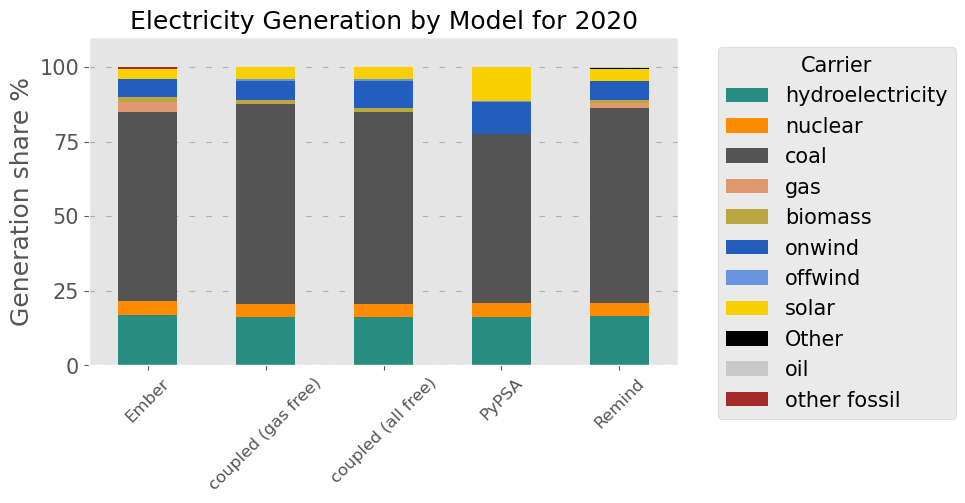

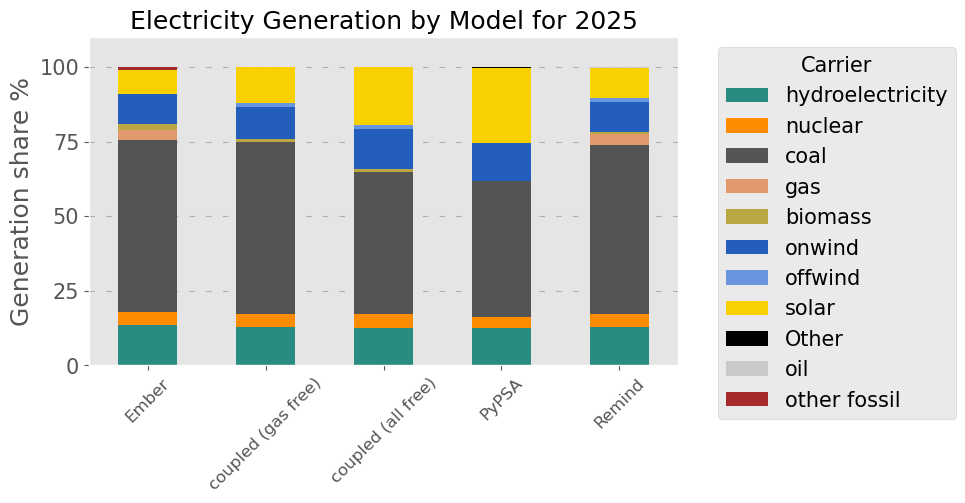

In [ ]:
# Plot the data dataframe for a selected year as stacked bars per results_path
for selected_year in years[:2]:
    plot_df =  data.loc[:,data.columns.get_level_values('year')==selected_year].copy()
    
    remind = plot_remind2.query("year==@selected_year").T.copy()
    remind = remind.rename(columns={remind.columns[0]: ("Remind", year)})
    plot_df = pd.concat([plot_df, remind], axis=1).fillna(0)

    plot_df.drop("electric load", inplace=True)
    plot_df.clip(lower=0, inplace=True)
    tot = plot_df.sum(axis=0)
    threshold = 0.2*tot/100
    plot_df[plot_df<=threshold] = 0
    plot_df = plot_df[(plot_df != 0).any(axis=1)]
    plot_df.loc["Other",:] = tot - plot_df.sum()
    # Prepare data for plotting: columns are (results_path, year), index is carrier
    data_year = plot_df/plot_df.sum()*100
    # data_year = data_year[abs(data_year)>0.1].dropna()
    # Prepare colors for carriers using config["plotting"]["tech_colors"], fallback to NAN_COLOR
    preferred_order = pd.Index(config["plotting"]["preferred_order"])
    # Reorder data_year to preferred_order, append missing carriers at the end
    new_index = preferred_order.intersection(data_year.index).append(
        data_year.index.difference(preferred_order)
    )
    data_year = data_year.loc[new_index].droplevel(1, axis=1)
    carrier_colors = []
    for carrier in data_year.index:
        carrier_colors.append(config["plotting"]["tech_colors"].get(carrier, NAN_COLOR))
    # Plot with colors
    ax = data_year.T.plot(
        kind="bar",
        stacked=True,
        figsize=(10, 6),
        color=carrier_colors
    )
    
    # Plot
    # ax = data_year.T.plot(kind="bar", stacked=True, figsize=(10, 6))
    ax.set_ylabel("Generation share %")
    ax.set_xlabel(None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.grid(axis='y', linestyle=(0, (5, 10)), alpha=0.7)
    ax.set_title(f"Electricity Generation by Model for {selected_year}", fontsize=18)
    ax.legend(title="Carrier", bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(data_year.clip(upper=0).sum().min() * 1.1, data_year.clip(lower=0).sum().max() * 1.1)
    plt.tight_layout()
    plt.xticks(rotation=45, fontsize=12)
    plt.show()



In [ ]:

dfs_in = {}
dfs_in["REMIND\n(gas kept free)"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-04_r22_ChrisRemind_freeze_c107/overnight_co2pw-SSP2-PkBudg1000-CHA-pypsaelh2_topo-current+FCG/"
dfs_in["unconstrained"] = "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-01-r23_uncoupled_c105/overnight_co2pw-SSP2-PkBudg1000-pseudo-coupled_topo-current+FCG"
prices = []
shares = []
for label, path in dfs_in.items():
    for year in years:
        df_pr = read_summary(path, year, cols=2, header=0, entry="weighted_prices").reset_index()
        pathway = df_pr.columns[-1]
        year = int(df_pr.loc[0, pathway])
        df_pr.set_index("co2_pathway", inplace=True)
        df_pr.drop("planning_horizons", inplace=True)
        df_pr.rename(columns = {pathway: (year, pathway)}, inplace=True)

        df = read_summary(path, year, cols=2, header=2, entry="supply_energy")
        balance_ac = df.loc["AC"].set_index("carrier").rename(columns={"Unnamed: 3": (label, year)})
        balance_ac.rename({"-": "electric load"}, inplace=True)
        balance_ac = balance_ac.groupby(level=0).sum().drop("H2 turbine")
        vre_share = balance_ac.clip(0).query("carrier in ['solar','offwind','onwind', 'hydroelectricity']").sum()/balance_ac.clip(0).sum()*100
        
        prices.append(df_pr)
        shares.append(vre_share.rename((label, year)))
prices_all = pd.concat(prices, axis=1)
prices_all.columns = pd.MultiIndex.from_tuples(prices_all.columns, names=[ "year", "results_path",])
shares_all = pd.concat(shares, axis=0)
shares_all.index = pd.MultiIndex.from_tuples(shares_all.index, names=["results_path", "year"])
shares_all = shares_all.unstack(1)
prices_all.dropna(inplace=True)


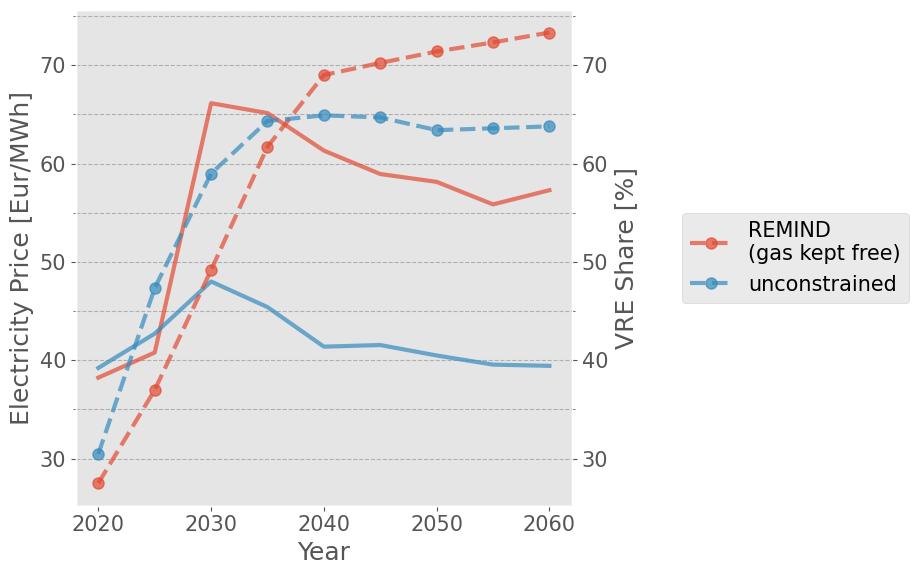

In [ ]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax.twinx()  # Create a second y-axis for the share plot
prices_all.unstack().droplevel(2).unstack().plot(ax = ax, lw = 3, alpha=0.7)
shares_all.T.plot(ax=ax2, lw=3, marker='o', markersize=8, alpha=0.7, ls = "--")
ax.set_ylabel("Electricity Price [Eur/MWh]")
ax2.set_ylabel("VRE Share [%]")
ax.set_xlabel("Year")
ax.legend_.remove()
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, which='minor')
ax.set_ylim(ax2.get_ylim())
plt.tight_layout()
plt.show()

Text(0, 0, 'REMIND\n(gas kept free)')
Text(0, 0, 'unconstrained')
Text(0, 0, '\nQuantity')
Text(0, 0, 'Price')
Text(0, 0, 'VRE share')


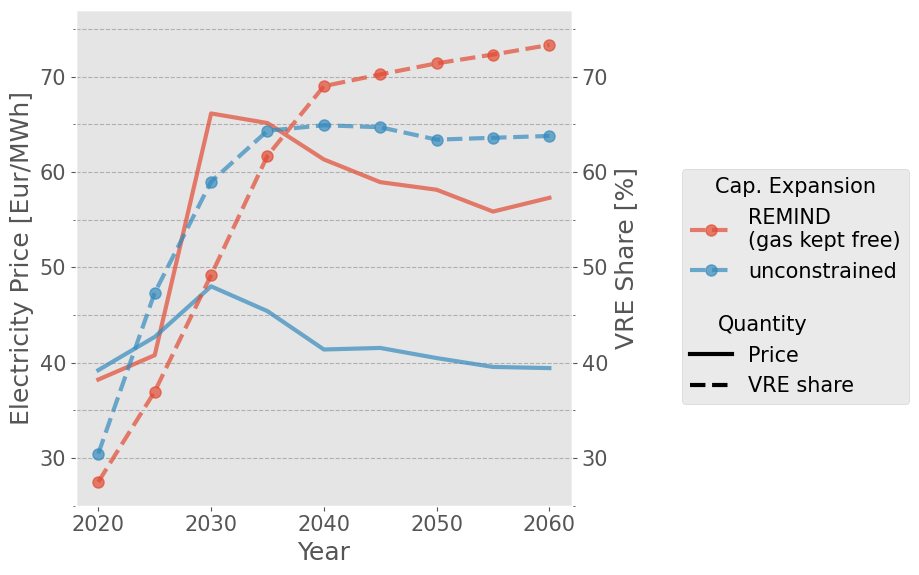

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax.twinx()  # Create a second y-axis for the share plot

# Plot solid and dashed lines
prices_all.unstack().droplevel(2).unstack().plot(ax=ax, lw=3, alpha=0.7)
shares_all.T.plot(ax=ax2, lw=3, marker='o', markersize=8, alpha=0.7, ls="--")

ax.set_ylabel("Electricity Price [Eur/MWh]")
ax2.set_ylabel("VRE Share [%]")
ax.set_xlabel("Year")
ax.legend_.remove()
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax2.plot([2025], [0], color="none", label="\nQuantity", lw=0)  # Dummy line for legend
# Add custom legend for solid and dashed lines, appending to existing legend
handles, labels = ax2.get_legend_handles_labels()
custom_lines = [
    Line2D([0], [0], color='black', lw=3, linestyle='-'),
    Line2D([0], [0], color='black', lw=3, linestyle='--')
]
handles += custom_lines
labels += ['Price', 'VRE share']
ax2.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.2, 0.7), title="Cap. Expansion")

leg = ax2.get_legend()
## Move titles to the left 
for item, label in zip(leg.legend_handles, leg.texts):
    print(label)
    if label._text  in ["Cap. Expansion","\nQuantity"]:
        width=item.get_window_extent(fig.canvas.get_renderer()).width
        label.set_ha('left')
        label.set_position((-1*width,0))

ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.grid(True, axis='y', linestyle='--', alpha=0.7, which='minor')
ax.set_ylim([25, ax2.get_ylim()[-1]])
ax2.set_ylim([25, ax2.get_ylim()[-1]])
plt.tight_layout()
plt.show()

In [ ]:

# def threshold(df, treshold = 0.2, name = "Other"):
#     pass


# # Identify carriers where all values are below threshold
# small_mask = (data_year.abs() < threshold).all(axis=1)

# # Sum small values into "Other"
# other_row = data_year[small_mask].sum()

# # Remove small rows and append "Other"
# data_year_grouped = data_year[~small_mask].copy()
# if other_row.sum() != 0:
#     data_year_grouped.loc["Other"] = other_row

# data_year_grouped